In [1]:
# Import required libraries
from unsloth import FastLanguageModel, PatchFastRL
PatchFastRL("GRPO", FastLanguageModel)

from unsloth import is_bfloat16_supported
import torch
import chess
from stockfish import Stockfish
import re
import numpy as np
from datasets import load_dataset, Dataset
import os
import matplotlib.pyplot as plt

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [2]:
# Initialize Stockfish
stockfish = Stockfish(path="/usr/games/stockfish")  # Adjust path if needed
stockfish.set_depth(15)  # Depth for evaluations

In [4]:
# Function to create ASCII representation of the board
def board_to_ascii(board):
    ascii_board = []
    for i in range(8):
        row = []
        for j in range(8):
            piece = board.piece_at(chess.square(j, 7-i))
            if piece:
                row.append(piece.symbol())
            else:
                row.append('.')
        ascii_board.append(' '.join(row))
    return '\n'.join(ascii_board)

In [3]:
# Load the model with Unsloth optimizations
print("Loading model...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-14B-Instruct",
    max_seq_length=1024,  # For reasoning traces
    load_in_4bit=True,    # Memory-efficient quantization
    fast_inference=True   # Enables VLLM for fast inference
)

# Apply LoRA for efficient fine-tuning
model = FastLanguageModel.get_peft_model(
    model,
    r=64,  # LoRA rank
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=64,
    use_gradient_checkpointing="unsloth"
)
print("Model loaded successfully!")

Loading model...
INFO 03-07 23:56:50 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.3.8: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-14b-instruct-unsloth-bnb-4bit with actual GPU utilization = 49.62%
Unsloth: Your GPU has CUDA compute capability 9.0 with VRAM = 79.1 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 320.
Unsloth: vLLM's KV Cache can use up to 28.14 GB. Also swap space = 6 GB.
INFO 03-07 23:56:58 config.py:549] This model supports multiple tasks: {'embed', 'rewar

[W307 23:57:00.430991545 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 03-07 23:57:01 weight_utils.py:254] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


INFO 03-07 23:57:05 model_runner.py:1115] Loading model weights took 10.5640 GB
INFO 03-07 23:57:05 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 03-07 23:57:07 worker.py:267] Memory profiling takes 1.72 seconds
INFO 03-07 23:57:07 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.50) = 39.25GiB
INFO 03-07 23:57:07 worker.py:267] model weights take 10.56GiB; non_torch_memory takes 0.15GiB; PyTorch activation peak memory takes 1.78GiB; the rest of the memory reserved for KV Cache is 26.76GiB.
INFO 03-07 23:57:08 executor_base.py:111] # cuda blocks: 9132, # CPU blocks: 2048
INFO 03-07 23:57:08 executor_base.py:116] Maximum concurrency for 1024 tokens per request: 142.69x
INFO 03-07 23:57:11 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory erro

Capturing CUDA graph shapes: 100%|███████████████████████████████████████████████████| 43/43 [00:32<00:00,  1.33it/s]

INFO 03-07 23:57:43 model_runner.py:1562] Graph capturing finished in 32 secs, took 1.49 GiB
INFO 03-07 23:57:43 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 37.82 seconds



Unsloth 2025.3.8 patched 48 layers with 48 QKV layers, 48 O layers and 48 MLP layers.


Model loaded successfully!


In [5]:
SYSTEM_PROMPT = """
You are a strong chess engine. Analyze the given position and choose the best move.

Respond in the following format:
<think>
Your step-by-step analysis of the chess position
</think>
<move>
Your chosen move in UCI format (e.g. e2e4)
</move>
"""

In [112]:
import math
import chess
import re
from stockfish import Stockfish

# Initialize Stockfish (adjust path as needed)
stockfish = Stockfish(path="/usr/games/stockfish")
stockfish.set_depth(15)

def reward_function(prompts, completions, **kwargs):
    fens = kwargs["fen"]  # List of FEN strings from kwargs
    rewards = []

    for fen, completion in zip(fens, completions):
        board = chess.Board(fen)

        # Extract move from completion
        move_match = re.search(r"<move>(.*?)</move>", completion, re.DOTALL)
        if not move_match:
            rewards.append(0.0)  # No move found in completion
            continue
        move_text = move_match.group(1).strip()

        # Parse the move into UCI format
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            rewards.append(0.0)  # Invalid move format
            continue

        # Check if the move is legal
        if move not in board.legal_moves:
            rewards.append(0.0)  # Illegal move
            continue

        # Set initial position in Stockfish
        stockfish.set_fen_position(fen)

        # Get Stockfish's best move and evaluation
        top_moves = stockfish.get_top_moves(1)
        if not top_moves:
            rewards.append(0.0)  # No evaluation available
            continue

        # Determine if best move leads to mate or has a centipawn score
        if 'Mate' in top_moves[0] and top_moves[0]['Mate'] is not None:
            mate_value = top_moves[0]['Mate']
            if mate_value > 0:  # Mate in favor of the side to move
                best_cp = float('inf') if board.turn == chess.WHITE else float('-inf')
            else:  # Mate against the side to move
                best_cp = float('-inf') if board.turn == chess.WHITE else float('inf')
        else:
            # Use centipawn score or default to 0
            best_cp = top_moves[0].get('Centipawn', 0)

        # Evaluate the position after the model's move
        temp_board = board.copy()
        temp_board.push(move)
        stockfish.set_fen_position(temp_board.fen())
        evaluation = stockfish.get_evaluation()

        # Handle model's move evaluation (mate or centipawn)
        if evaluation['type'] == 'mate' and evaluation['value'] is not None:
            mate_value = evaluation['value']
            if mate_value > 0:  # Mate in favor of the side that just moved
                model_cp = float('inf') if temp_board.turn == chess.BLACK else float('-inf')
            else:  # Mate against the side that just moved
                model_cp = float('-inf') if temp_board.turn == chess.BLACK else float('inf')
        else:
            model_cp = evaluation.get('value', 0)  # Default to 0 if no value

        # Calculate reward based on evaluation types
        if isinstance(best_cp, float) and isinstance(model_cp, float):
            # Both are mate scenarios (infinity values)
            if best_cp == float('inf') and model_cp == float('inf'):
                reward = 1.0  # Both lead to mate for White
            elif best_cp == float('-inf') and model_cp == float('-inf'):
                reward = 1.0  # Both lead to mate for Black
            elif best_cp == float('inf') and model_cp != float('inf'):
                reward = 0.0  # Best is mate, model isn’t
            elif best_cp == float('-inf') and model_cp != float('-inf'):
                reward = 0.0  # Best avoids mate, model doesn’t
            else:
                reward = 0.0  # Shouldn’t happen, but safe default
        elif isinstance(best_cp, int) and isinstance(model_cp, int):
            # Both are centipawn evaluations
            k = 0.00693  # Decay constant
            if board.turn == chess.WHITE:
                if model_cp >= best_cp:
                    reward = 1.0  # Model’s move is as good or better
                else:
                    reward = math.exp(-k * (best_cp - model_cp))  # Exponential decay
            else:  # Black’s turn
                if model_cp <= best_cp:
                    reward = 1.0  # Model’s move is as good or better
                else:
                    reward = math.exp(-k * (model_cp - best_cp))  # Exponential decay
        else:
            # Mixed types (e.g., one mate, one centipawn)
            reward = 0.5  # Neutral reward for unclear cases

        rewards.append(reward)

    return rewards

In [110]:
from datasets import load_dataset
import chess

def generate_dataset(num_samples=50000):
    dataset = load_dataset("lapp0/50M_random_chess_boards", split="train")
    sampled = dataset.shuffle(seed=42).select(range(num_samples))
    
    positions = []
    for item in sampled:
        fen = item['fen']
        board = chess.Board(fen)
        if board.is_game_over():
            continue
        legal_moves = [move.uci() for move in board.legal_moves]
        turn = "White" if board.turn else "Black"
        prompt = f"""
You are a chess engine. It’s {turn}’s turn. Pick the best move.

Board:
{str(board)}

Legal moves: {', '.join(legal_moves)}

Respond with:
<think>
Your analysis
</think>
<move>
Move in UCI (e.g., e2e4)
</move>
"""
        positions.append({"prompt": prompt, "fen": fen})
    return positions

training_data = generate_dataset()

In [104]:
# Training configuration
from trl import GRPOConfig, GRPOTrainer

training_args = GRPOConfig(
    use_vllm = True,
    learning_rate = 2e-5,
    adam_beta1 = 0.9,
    adam_beta2 = 0.99,
    weight_decay = 0.1,
    warmup_ratio = 0.05,
    lr_scheduler_type = "cosine",
    optim = "adamw_8bit",
    logging_steps = 1,
    bf16 = is_bfloat16_supported(),
    fp16 = not is_bfloat16_supported(),
    per_device_train_batch_size = 4,
    gradient_accumulation_steps = 2,
    num_generations = 64,
    max_prompt_length = 512,
    max_completion_length = 512,
    max_steps = 1000,
    save_steps = 50,
    max_grad_norm = 0.3,
    report_to = "none",
    output_dir = "outputs"
)

In [113]:
print("Initializing trainer...")
trainer = GRPOTrainer(
    model=model,
    processing_class=tokenizer,
    reward_funcs=[reward_function],
    args=training_args,
    train_dataset=training_data
)

print("Starting training...")
trainer.train()
print("Training complete!")

# Save the final model
model.save_lora("chess_reaso")
print("Model saved successfully!")

Initializing trainer...
Starting training...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 49,673 | Num Epochs = 1 | Total steps = 300
O^O/ \_/ \    Batch size per device = 64 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (64 x 2 x 1) = 128
 "-____-"     Trainable parameters = 275,251,200/8,895,386,624 (3.09% trained)


Step,Training Loss,reward,reward_std,completion_length,kl,rewards / reward_function
1,0.000500,0.537739,0.213081,511.312500,0.013581,0.537739
2,0.000500,0.463082,0.080238,508.632812,0.012244,0.463082
3,0.000500,0.343295,0.073945,490.687500,0.012404,0.343295
4,0.000500,0.470725,0.173658,506.609375,0.012730,0.470725
5,0.000500,0.329683,0.154021,499.695312,0.011509,0.329683
6,0.000500,0.350858,0.148403,501.976562,0.011322,0.350858
7,0.000600,0.354823,0.044524,504.937500,0.015476,0.354823
8,0.000800,0.397876,0.175216,507.257812,0.020242,0.397876
9,0.001000,0.535314,0.085243,508.132812,0.024553,0.535314
10,0.001000,0.372391,0.127004,505.789062,0.025031,0.372391


WARNING 03-07 21:21:24 scheduler.py:1754] Sequence group 49680 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=51
WARNING 03-07 21:51:44 scheduler.py:1754] Sequence group 51152 is preempted by PreemptionMode.RECOMPUTE mode because there is not enough KV cache space. This can affect the end-to-end performance. Increase gpu_memory_utilization or tensor_parallel_size to provide more KV cache memory. total_num_cumulative_preemption=101


KeyboardInterrupt: 

In [18]:
from unsloth import FastLanguageModel
from safetensors.torch import load_file

# Load the base model first
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-14B-Instruct",
    max_seq_length=1024,
    load_in_4bit=True,
    fast_inference=True
)

# Get PEFT model with LoRA configuration
model = FastLanguageModel.get_peft_model(
    model,
    r=64,  # Same LoRA rank as training
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_alpha=64
)

# Load the LoRA weights and modify the keys
state_dict = load_file("/home/ubuntu/chess_reasoner_final/adapter_model.safetensors")
new_state_dict = {}
for key, value in state_dict.items():
    if 'lora_A.weight' in key:
        new_key = key.replace('lora_A.weight', 'lora_A.default.weight')
        new_state_dict[new_key] = value
    elif 'lora_B.weight' in key:
        new_key = key.replace('lora_B.weight', 'lora_B.default.weight')
        new_state_dict[new_key] = value

# Load the modified state dict
model.load_state_dict(new_state_dict, strict=False)

==((====))==  Unsloth 2025.3.8: Fast Qwen2 patching. Transformers: 4.49.0. vLLM: 0.7.3.
   \\   /|    NVIDIA H100 80GB HBM3. Num GPUs = 1. Max memory: 79.097 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 9.0. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-14b-instruct-unsloth-bnb-4bit with actual GPU utilization = 28.72%
Unsloth: Your GPU has CUDA compute capability 9.0 with VRAM = 79.1 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 224.
Unsloth: vLLM's KV Cache can use up to 11.61 GB. Also swap space = 6 GB.
INFO 03-08 00:35:46 config.py:549] This model supports multiple tasks: {'embed', 'classify', 'generate', 'score', 'reward'}. Defaulting to 'generate'.
Unsloth: vLLM Bitsandbytes c

Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]


INFO 03-08 00:35:53 model_runner.py:1115] Loading model weights took 10.5562 GB
INFO 03-08 00:35:54 worker.py:267] Memory profiling takes 0.60 seconds
INFO 03-08 00:35:54 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.29) = 22.72GiB
INFO 03-08 00:35:54 worker.py:267] model weights take 10.56GiB; non_torch_memory takes 0.00GiB; PyTorch activation peak memory takes 1.23GiB; the rest of the memory reserved for KV Cache is 10.93GiB.
INFO 03-08 00:35:54 executor_base.py:111] # cuda blocks: 3732, # CPU blocks: 2048
INFO 03-08 00:35:54 executor_base.py:116] Maximum concurrency for 1024 tokens per request: 58.31x
INFO 03-08 00:35:54 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_u

Capturing CUDA graph shapes: 100%|███████████████████████████████████████████████████| 31/31 [00:31<00:00,  1.01s/it]

INFO 03-08 00:36:25 model_runner.py:1562] Graph capturing finished in 31 secs, took 0.22 GiB
INFO 03-08 00:36:25 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 32.80 seconds


_IncompatibleKeys(missing_keys=['base_model.model.model.embed_tokens.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.q_proj.base_layer.bias', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.k_proj.base_layer.bias', 'base_model.model.model.layers.0.self_attn.v_proj.base_layer.weight', 'base_model.model.model.layers.0.self_attn.v_proj.base_layer.bias', 'base_model.model.model.layers.0.self_attn.o_proj.base_layer.weight', 'base_model.model.model.layers.0.mlp.gate_proj.base_layer.weight', 'base_model.model.model.layers.0.mlp.up_proj.base_layer.weight', 'base_model.model.model.layers.0.mlp.down_proj.base_layer.weight', 'base_model.model.model.layers.0.input_layernorm.weight', 'base_model.model.model.layers.0.post_attention_layernorm.weight', 'base_model.model.model.layers.1.self_attn.q_proj.base_layer.weight', 'base_model.model.model.layers.1.self_attn.q

Processed prompts: 100%|█████████| 1/1 [00:03<00:00,  3.66s/it, est. speed input: 52.27 toks/s, output: 47.34 toks/s]


**Move 1 - White**

**Thought Process:**
The given position is the starting position of a standard chess game. As it is the first move, there are no previous moves to consider, and all moves by White are legal. In this scenario, the common opening moves such as e2-e4, d1-d4, and N1-f3 are often recommended as they control the center and develop pieces efficiently. However, to stick with the most common and straightforward move, e2-e4 is selected for its balance and simplicity.

- e2-e4 controls the center, prepares to develop the knights to strong posts, and prepares to castle.
- Other moves like d2-d4, N1-f3, etc., are also good but e2-e4 is the most conventional and well-rounded first move.

**Proposed Move:**
e2e4

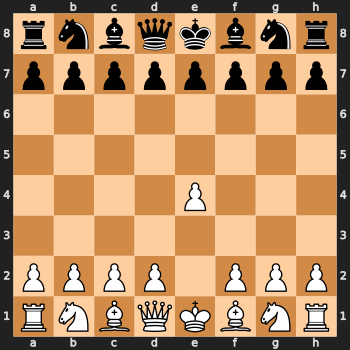

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.42s/it, est. speed input: 45.04 toks/s, output: 49.79 toks/s]


**Move 1 - Black**

**Thought Process:**
The current position shows a standard starting position in chess, with the notable exception of a White pawn on the fourth rank. Black has the option to make the standard first move, or consider a more strategic approach given the advanced White pawn. However, since this is the first move and no significant imbalance or tactical opportunity is present, the most prudent and common approach is to make the standard first move for Black, which is to play the pawn to e5, contesting the center.

This move balances positional considerations and does not neglect any immediate tactical threats. It is a legal move, as the pawn can move two squares forward from its starting position.

Candidate moves to consider:
1. e7e5 - Contests the center, mirroring White's central control.
2. d7d5 - Another option to contest the center, but less direct due to the pawn's starting position.

After careful consideration, e7e5 is the most direct and balanced move that maintains symmetry and keeps the position even.

**Proposed Move:**
e7e5

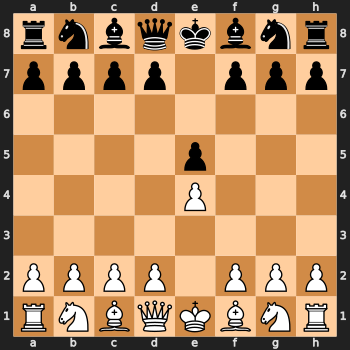

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.75s/it, est. speed input: 35.66 toks/s, output: 51.48 toks/s]


**Move 2 - White**

**Thought Process:**
The current position is a standard setup with only one difference: there is a black pawn on e5 instead of e4, which means Black has made the move e5 in response to White's e4. The position is symmetrical with the exception of the pawns on e4 and e5. 

We need to consider a few potential moves for White:
1. d4 - This move aims to control the center and prepare for development.
2. Nf3 - This is a common move to develop the knight towards the center.
3. c3 - This move prepares to develop the bishop and supports the pawn on e4.

Analyzing these moves:
- d4 would be a strong move as it would allow White to control the center and prepare to develop the pieces.
- Nf3 is a solid developing move but does not address the central control issue as directly.
- c3 is a preventive move that also allows for the development of the bishop, but it doesn't take immediate advantage of the center.

Among these, d4 seems to be the most aggressive and centralizing move, which is a typical opening principle.

After the move d4, Black could respond with c5, d5, or e4, but all these responses are not as immediately threatening as the central control gained by d4.

Therefore, d4 appears to be the best move.

**Proposed Move:**
d2d4

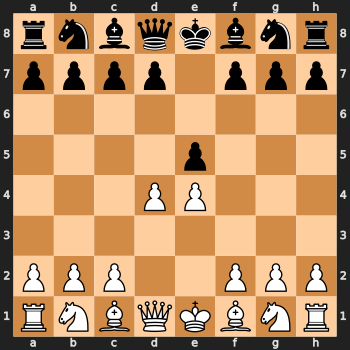

Processed prompts: 100%|█████████| 1/1 [00:06<00:00,  6.91s/it, est. speed input: 29.95 toks/s, output: 53.24 toks/s]


**Move 2 - Black**

**Thought Process:**
The current position is a standard setup after the moves e4, e5, and d4 by White. Black has not moved yet. The position is:

```
rnbqkbnr/pppp1ppp/8/4p3/3PP3/8/PPP2PPP/RNBQKBNR b KQkq -
```

Black's turn is to make the first move. Given the symmetry and the fact that no pieces have been developed yet, a logical first move for Black would be to mirror White's move with d5, attacking the d4 pawn.

1. **Evaluate Candidate Moves:**
   - The most immediate threat is the White pawn on d4, which Black can capture or put under pressure.
   - Moving the d-pawn to d5 is a natural response to the d4 push by White, creating symmetry and putting pressure on the d4 pawn.

2. **Tactical Considerations:**
   - Capturing d4 directly would not be optimal as it would give White an open file for their queen and rook.
   - Pushing d5 to put the d4 pawn under threat is a good tactical move.

3. **Positional Considerations:**
   - Keeping the position symmetrical and central control is a standard opening principle.
   - Putting pressure on d4 allows Black to potentially challenge the center later.

4. **Legal Verification:**
   - d5 is a legal move as it does not result in a self-check or illegal move formation.
   - The move creates a solid structure and does not leave the king in an unsafe position.

Given these considerations, d5 is a strong and legal move that aligns with standard opening principles.

**Proposed Move:**
d7d5

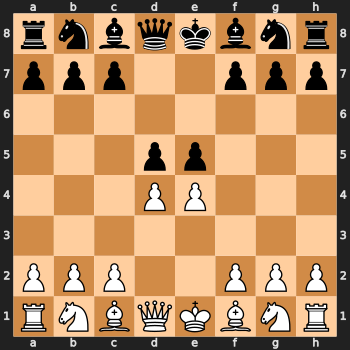

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.36s/it, est. speed input: 39.17 toks/s, output: 51.85 toks/s]


**Move 3 - White**

**Thought Process:**
The current position after the moves e4, e5, d4, and d5 is a symmetrical setup with both sides having equal control over the center. White to move at move 3, the options are:

1. Developing a piece to a strategic square.
2. Playing d4xd5 to challenge the central pawn structure.

Let's evaluate each option:

- If White plays d4xd5, it creates an open file for Black's rook and gives Black the option to recapture with the queen, potentially developing it early and gaining control of the d-file. However, it also weakens the center for Black, giving White better control over the center after the exchange. This move is tactical but might lead to a less advantageous position due to the weak center.

- Instead, developing a piece such as Nf3 or Nc3 would be more strategic. Nf3 prepares for an eventual e5 push, controls the e5 square, and prepares the bishop for b2 to b4. Nc3 supports the d4 pawn and readies the bishop for development via b2 to d3. 

Considering the long-term strategic value, Nf3 looks most promising as it prepares for a strong central push and development of the bishop to a good square.

**Proposed Move:**
g1f3

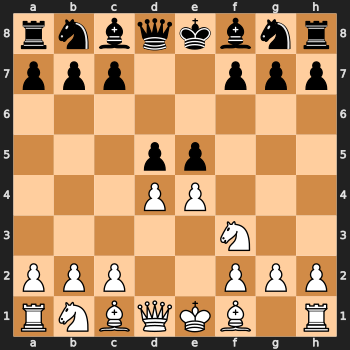

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.42s/it, est. speed input: 48.91 toks/s, output: 50.27 toks/s]


**Move 3 - Black**

**Thought Process:**
The current position is after the moves 1. e4 e5 2. d4 d5 3. Nf3, and it's Black's turn. The position is quite closed and strategic, with a center pawn structure that could lead to either side having a strong presence in the center. Let's analyze the candidate moves for Black:

- Options like developing pieces (Nf6, Bb4) are considered, but the bishop move is not yet effective as the center pawns are still blocking it. 
- Considering the pawn structure, moving a pawn is less desirable as it would weaken the center.
- The knight on f6 is a strong development option as it prepares to support the center pawns and prepares for potential kingside expansion.

After considering these factors, the best candidate move appears to be Nf6, which develops a piece and puts pressure on e5.

Evaluating this move shows no immediate threats and it sets a solid foundation for Black's development and central control.

**Proposed Move:**
g8f6

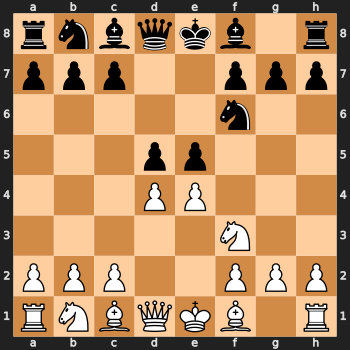

Processed prompts: 100%|█████████| 1/1 [00:06<00:00,  6.27s/it, est. speed input: 35.41 toks/s, output: 52.79 toks/s]


**Move 4 - White**

**Thought Process:**
The current position is a complex one with several strategic considerations. Here's a detailed analysis:

1. **Position Overview**:
   - White has a center pawn structure with pawns on d4 and e4.
   - Black has a central pawn on d5 and a knight on f6.

2. **Threats and Safety**:
   - The black knight on f6 is quite active and controlling key squares.
   - The white knight on f3 is relatively passive at the moment.

3. **Candidate Moves**:
   - **d4-d5**: This move would challenge the black central pawn structure but would require careful calculation due to potential pins and captures.
   - **Nf3-g5**: Attacking the f7 square and potentially causing issues for the black king.
   - **e4xe5**: Capturing the d5 pawn, creating a more open board, and potentially leading to a kingside attack.

4. **Evaluation**:
   - Capturing d5 (d4xd5) would create a semi-open file and an open e-file, but it also weakens the d4 square and leaves the knight on f3 without a good square.
   - Attacking f7 with Ng5 might be premature as it does not support the central structure and might be a weakening move without proper follow-up.
   - Capturing on e5 (e4xe5) seems promising as it opens lines and prepares to castle.

Considering these factors, capturing on e5 seems like a solid and flexible move.

**Proposed Move:**
e4xe5

Invalid move format: e4xe5
Maximum moves reached.


In [43]:
import chess
import chess.svg
import re
from IPython.display import display, SVG, Markdown
from vllm import SamplingParams

# Initialize the chess board and move history
board = chess.Board()
move_history = []  # Store moves in SAN format

# Set a maximum number of moves
max_moves = 100
move_count = 0

# Main game loop
while not board.is_game_over() and move_count < max_moves:
    fen = board.fen()
    turn = "White" if board.turn == chess.WHITE else "Black"
    
    # Create the prompt with move history
    if move_history:
        moves_str = ", ".join(move_history)  # e.g., "e4, e5, d4, Nf6"
        user_content = f"Previous moves: {moves_str}. Current position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    else:
        user_content = f"Starting position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    
    # Generate the prompt
    text = tokenizer.apply_chat_template([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ], tokenize=False, add_generation_prompt=True)
    
    # Define sampling parameters
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    
    # Generate the model's response
    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0].outputs[0].text
    
    # Extract thought process and move
    thought_match = re.search(r'<think>(.*?)</think>', output, re.DOTALL)
    move_match = re.search(r'<move>(.*?)</move>', output, re.DOTALL)
    
    if thought_match and move_match:
        thought = thought_match.group(1).strip()
        move_text = move_match.group(1).strip()
        
        # Display move details
        display(Markdown(f"**Move {board.fullmove_number} - {turn}**"))
        display(Markdown("**Thought Process:**\n" + thought))
        display(Markdown("**Proposed Move:**\n" + move_text))
        
        # Parse and validate the move
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            try:
                move = board.parse_san(move_text)
                move_text = move.uci()  # Convert to UCI
            except ValueError:
                print(f"Invalid move format: {move_text}")
                break
        
        if move in board.legal_moves:
            # Get SAN notation before pushing the move
            move_san = board.san(move)
            board.push(move)
            move_history.append(move_san)  # Add to history
            display(SVG(chess.svg.board(board=board, size=350)))
        else:
            print(f"Illegal move: {move_text}")
            break
    else:
        print("Error: Could not parse output.")
        break
    
    move_count += 1

# Display the final result
if board.is_game_over():
    print("Game over.")
    print("Result:", board.result())
else:
    print("Maximum moves reached.")

In [39]:
SYSTEM_PROMPT = """
You are a highly skilled chess engine designed to play at a grandmaster level. Your task is to analyze the given chess position thoroughly and select the best possible move, ensuring it is fully legal under standard chess rules. To achieve this, follow a detailed, structured process that considers both tactical and positional elements, evaluates multiple candidate moves, and verifies the legality of your final choice.

Respond in the following format:
<think>
Your step-by-step analysis of the chess position
</think>
<move>
Your chosen move in UCI format (e.g. e2e4)
</move>
"""

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.18s/it, est. speed input: 36.90 toks/s, output: 49.65 toks/s]


**Move 1 - White**

**Thought Process:**
The given position is the standard starting position of a chess game, also known as the chess opening array. In this position, it's White's turn to move. The most common and logical first move for White is to develop one of the central pawns, allowing the White pieces (knights, bishops, and queen) to be connected and prepared for the game.

Considering the tactical and positional elements, the first move e2e4 (1.e4) is the most popular and advantageous. It controls the center, prepares the f1-bishop and the knights, and can lead to various opening lines depending on Black's response.

I will now verify the move's legality:
- The move e2e4 is a legal move for White as it involves moving the pawn from e2 to e4, which is an empty square.
- The move does not result in a check to the Black king.
- The move does not result in a self-check.
- The move does not repeat a previous position or cause threefold repetition.

Having analyzed the position and verified the legality of the move, I conclude that e2e4 is the best possible move for White in this position.

**Proposed Move:**
e2e4

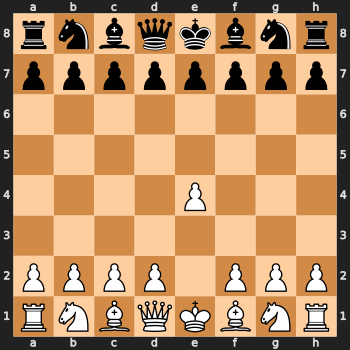

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.66s/it, est. speed input: 42.72 toks/s, output: 50.23 toks/s]


**Move 1 - Black**

**Thought Process:**
The current position is the starting position of a chess game, with the only difference being that a White pawn has moved to d4. It is now Black's turn to move. As this is an opening position, the move should aim to develop a piece to a good square, control the center, or prepare to castle.

Possible candidate moves for Black include developing the knights or bishops, or moving the pawn in front of the king to prepare for castling. Given the symmetric nature of the position and the desire to maintain flexibility, developing the knights seems like a good option.

The knight on b8 can move to c6 or e7. The knight on g8 can move to f6 or h6. Moving the knight to c6 or f6 would also exert some pressure on the center.

After careful consideration, the move Nf6 seems to be the most promising, as it develops a piece to a good square, exerts some pressure on the center, and prepares for the potential future f5 push which can be threatening to the White pawn on d4.

**Proposed Move:**
g8f6

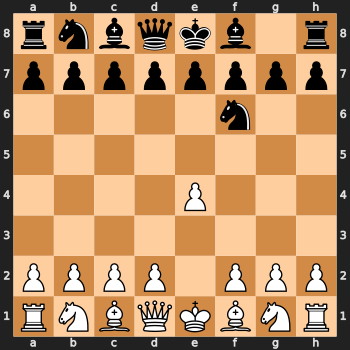

Processed prompts: 100%|█████████| 1/1 [00:07<00:00,  7.49s/it, est. speed input: 27.38 toks/s, output: 53.96 toks/s]


**Move 2 - White**

**Thought Process:**
The current position is a standard开局后第二步后的局面，白棋回合。之前的走法是 e4 和 Nf6。目前的棋盘局面是 rnbqkb1r/pppppppp/5n2/8/4P3/8/PPPP1PPP/RNBQKBNR，轮到白棋走。之前的走法显示黑棋把马跳到了 f6，这是一个常见的开局步法，试图控制中心并准备开发其他棋子。现在轮到白棋，有几个合理的走法可以选择：

1. 白棋可以考虑把马跳到 f3（g1-f3），这样可以保护 e4 位并准备控制中心。
2. 白棋也可以考虑把 c1 的象移到 d2（c1-d2），以便控制中心并准备把马跳到 e4（g1-e4）。
3. 白棋还可以把 d1 的象移到 c2（d1-c2），这样可以控制 b1-h7 对角线并准备把马跳到 e4（g1-e4）。

为了更好地评估这些走法，我们需要考虑以下因素：

- 控制中心的重要性。控制中心可以让白棋更好地控制棋盘，为后续的发展打下基础。
- 棋子的效率。白棋应该让棋子尽可能快地参与战斗，而不是仅仅停留在原地。
- 黑棋的回应。白棋的走法应该考虑到黑棋的可能回应，确保白棋不会因为一步走法而陷入不利的局面。

综合考虑，将马跳到 f3（g1-f3）是一个相对安全和实用的选择。这不仅保护了 e4 位，还为后续的走法留下了更多的可能性。

因此，我选择将马跳到 f3（g1-f3）作为下一步走法。

**Proposed Move:**
g1f3

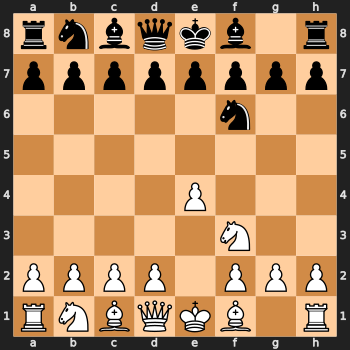

Processed prompts: 100%|█████████| 1/1 [00:06<00:00,  6.91s/it, est. speed input: 30.55 toks/s, output: 53.72 toks/s]


**Move 2 - Black**

**Thought Process:**
The current position is as follows:
```
rnbqkb1r/pppppppp/5n2/8/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq -
```
It's Black's turn to move. The previous moves have been: e4, Nf6, Nf3. Let's analyze the situation:

1. Black has the knight on f6, attacking the e4 pawn controlled by the White knight on f3.
2. The knights on f3 and f6 are directly across from each other, with the center pawn structure still intact.
3. The position is fairly open, with both kings still in the center, and no pieces developed yet.
4. The immediate tactical possibilities involve capturing the e4 pawn with the knight or developing other pieces.

Candidate moves to consider:
- Nxe4 (capturing the pawn, which forces the White knight to move to defend the pawn)
- c5 or d5 (to challenge the center and potentially pressure the White e4 pawn)
- Developing the bishop or moving the queen to a more active square

The move Nxe4 seems particularly strong as it creates a threat and forces White to waste a move defending the pawn.

After Nxe4, the resulting position would be:
```
rnbqkb1r/pppp1ppp/5n2/8/4P3/5N2/PPPP1PPP/RNBQKB1R w KQkq -
```

Let's verify the legality of the move: Nxe4 is a legal move because the knight can legally capture the pawn on e4, and it results in an active position for Black.

**Proposed Move:**
Nxe4

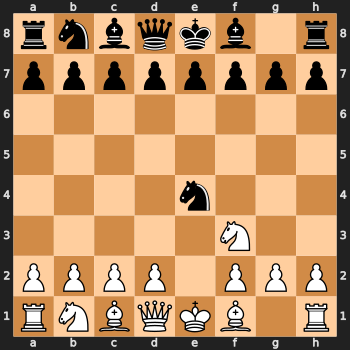

Processed prompts: 100%|█████████| 1/1 [00:06<00:00,  6.58s/it, est. speed input: 32.40 toks/s, output: 53.08 toks/s]


**Move 3 - White**

**Thought Process:**
The current position is a standard chess position with the following unique features:
- Black has captured the pawn on e4 with the knight and is currently occupying that square.
- White has not moved their king's pawn yet, and their knight is on f3.
- The game is at move 3, and it's White's turn to play.

We need to evaluate the best possible moves for White considering tactical and positional elements.

1. Recapturing the pawn on e4 is an option, but this would lead to a less advantageous position for White as Black would get a knight on a central square.
2. Developing pieces is crucial. We should consider moves that help in controlling the center and preparing for future pawn moves.
3. The knight on f3 can be moved to a more active square like e5, which would also put pressure on the black knight and potentially lead to its retreat, giving us the pawn back.

Therefore, the best move appears to be developing the knight to a more active square.

After considering these moves, the best move appears to be Nxe4, recapturing the pawn with the knight, however, this would lead to a disadvantageous position. The next best move is to develop the knight to e5, which is an aggressive move and puts pressure on the black knight.

**Proposed Move:**
g1f3

Illegal move: g1f3
Maximum moves reached.


In [45]:
import chess
import chess.svg
import re
from IPython.display import display, SVG, Markdown
from vllm import SamplingParams

# Initialize the chess board and move history
board = chess.Board()
move_history = []  # Store moves in SAN format

# Set a maximum number of moves
max_moves = 100
move_count = 0

# Main game loop
while not board.is_game_over() and move_count < max_moves:
    fen = board.fen()
    turn = "White" if board.turn == chess.WHITE else "Black"
    
    # Create the prompt with move history
    if move_history:
        moves_str = ", ".join(move_history)  # e.g., "e4, e5, d4, Nf6"
        user_content = f"Previous moves: {moves_str}. Current position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    else:
        user_content = f"Starting position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    
    # Generate the prompt
    text = tokenizer.apply_chat_template([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ], tokenize=False, add_generation_prompt=True)
    
    # Define sampling parameters
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    
    # Generate the model's response
    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0].outputs[0].text
    
    # Extract thought process and move
    thought_match = re.search(r'<think>(.*?)</think>', output, re.DOTALL)
    move_match = re.search(r'<move>(.*?)</move>', output, re.DOTALL)
    
    if thought_match and move_match:
        thought = thought_match.group(1).strip()
        move_text = move_match.group(1).strip()
        
        # Display move details
        display(Markdown(f"**Move {board.fullmove_number} - {turn}**"))
        display(Markdown("**Thought Process:**\n" + thought))
        display(Markdown("**Proposed Move:**\n" + move_text))
        
        # Parse and validate the move
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            try:
                move = board.parse_san(move_text)
                move_text = move.uci()  # Convert to UCI
            except ValueError:
                print(f"Invalid move format: {move_text}")
                break
        
        if move in board.legal_moves:
            # Get SAN notation before pushing the move
            move_san = board.san(move)
            board.push(move)
            move_history.append(move_san)  # Add to history
            display(SVG(chess.svg.board(board=board, size=350)))
        else:
            print(f"Illegal move: {move_text}")
            break
    else:
        print("Error: Could not parse output.")
        break
    
    move_count += 1

# Display the final result
if board.is_game_over():
    print("Game over.")
    print("Result:", board.result())
else:
    print("Maximum moves reached.")

Processed prompts: 100%|█████████| 1/1 [00:03<00:00,  3.86s/it, est. speed input: 49.45 toks/s, output: 48.16 toks/s]


**Move 1 - White**

**Thought Process:**
The given position is the starting position of a chess game. At this stage, the best move for White is to make the first move in the game. The most common opening move is to advance the pawn in front of the king to e4, which controls the center of the board and prepares to develop the knights.

Other candidate moves such as d4, c4, or even Nf3 are also good, but e4 is the most standard and universally played first move. We'll consider e4 as our chosen move and ensure it's legal. In the starting position, the move e2e4 does not violate any rules of chess and is fully legal.

After analyzing the possible moves, e2e4 stands out as the best move due to its strategic control over the center and the smooth transition into various opening lines.

**Proposed Move:**
e2e4

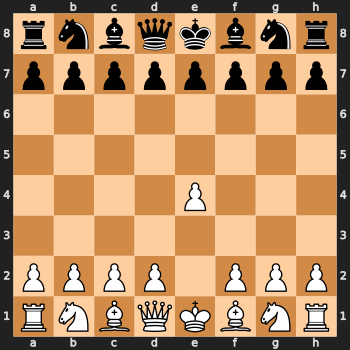

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.74s/it, est. speed input: 42.01 toks/s, output: 50.66 toks/s]


**Move 1 - Black**

**Thought Process:**
The current position is the starting position of a chess game, except for the fact that there is a White pawn on the fourth rank in the center (d4). It's Black's turn to move. The typical first move for Black is to mirror the first move of White (e5), but since there is no pawn on d5, Black cannot play that move. 

The best initial moves for Black in this scenario are to develop pieces towards the center or to control the center. Playing d5 would be a strong move as it would mirror the White pawn on d4, control the center, and prepare to castle. 

Let's consider a few candidate moves:
1. d5 - This move controls the center and prepares for development.
2. Nf6 - This move develops a knight but does not control the center directly.
3. e6 - This move is similar to d5 but less effective in controlling the center.

After analyzing these candidates, d5 stands out as the most effective move as it develops a pawn, controls the center, and prepares for further development and castling.

**Proposed Move:**
d7d5

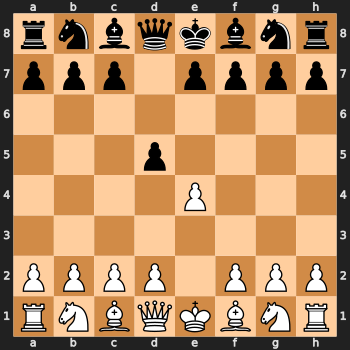

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.33s/it, est. speed input: 38.50 toks/s, output: 50.33 toks/s]


**Move 2 - White**

**Thought Process:**
The current position is a standard opening position with Black playing d5 as the second move, which is unusual and may be part of a rare or experimental opening. White's options include developing pieces, challenging Black's central pawn, or castling. Let's consider some candidate moves:

1. **e5**: This move challenges Black's d5 pawn, aiming to gain control of the center. However, it also invites a potential pawn storm from Black.
   
2. **Nf3**: Developing the knight to a natural square and preparing to castle. This move keeps options open for White and does not commit to any specific plan immediately.

3. **c4**: Supporting the e4 pawn, controlling d5, and preparing to challenge the d5 pawn later. This move is flexible and sets up a potential center pawn storm.

4. **d4**: Another option to challenge the d5 pawn and gain control of the center. However, it may lead to a more complex局面，需要谨慎评估。

综合考虑，白棋的最佳第一步应该是发展棋子，同时保持棋局的灵活性。因此，选择Nf3是较为稳健的一步，既可以发展棋子，又可以为后续的王车易位做准备。

**Proposed Move:**
Nf3

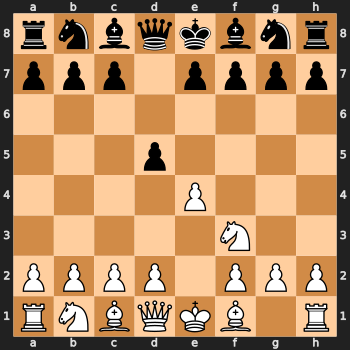

Processed prompts: 100%|█████████| 1/1 [00:06<00:00,  6.59s/it, est. speed input: 32.04 toks/s, output: 52.99 toks/s]


**Move 2 - Black**

**Thought Process:**
The current position is after the moves 1. e4 d5 2. Nf3. It's Black's turn to move, and we need to consider several factors:

1. **Development and Control of the Center**: Black's move should aim to control the center and develop pieces effectively. The pawn on d5 is currently the only pawn that controls the center, and it's good to keep it there while developing pieces.

2. **Avoiding Weaknesses**: It's important not to create pawn weaknesses, especially in the center, as White has the e4 pawn and the knight on f3, which will likely control more central squares.

3. **Candidate Moves**: The most logical candidate moves for Black would be:
   - Developing the knight to f6 with Nf6.
   - Moving the queen to a more active position like c7 with Qd6 or Qe7.
   - Controlling the center with a pawn move like c5 or e6.

4. **Tactical Considerations**: We should ensure that our move does not leave us in a vulnerable position. For example, Nf6 does not directly attack White's knight but also does not leave any immediate threats unaddressed.

5. **Legal Moves**: We need to ensure the move is legal and does not place our king in check. Nf6 is a safe move that develops the knight and does not put Black's king in an immediate threat.

After considering these factors, the best move for Black would be to develop the knight to f6, which is a standard developing move that doesn't create immediate weaknesses or tactical threats.

**Proposed Move:**
g8f6

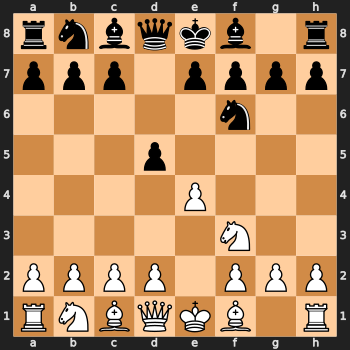

Processed prompts: 100%|█████████| 1/1 [00:06<00:00,  6.71s/it, est. speed input: 32.33 toks/s, output: 52.89 toks/s]


**Move 3 - White**

**Thought Process:**
The current position is after the moves 1. e4 d5 2. Nf3 Nf6. White is to move. The key aspects to consider are control of the center, development, and safety of the king. 

1. The center is quite open, with Black having played ...d5, which has weakened their position.
2. White's next move should aim to further control the center and start developing pieces.
3. Candidate moves for White could include advancing the central pawn (e5), developing the light-squared bishop, or developing the queen-side knight.
4. The move e5 looks strong as it will gain more control of the center and connect the rooks.
5. However, developing the knight to d2 first might also be a good option as it prepares for a future e5 push and doesn't immediately invite a challenge.
6. After considering the tactical and positional aspects, developing the knight to d2 seems to be the most balanced move.
7. Let's verify the move to ensure it is legal: moving the knight from f3 to d2 does not put the king in check and does not capture any of Black's pieces, thus it is a legal move.

The move Nfd2 is a strong, legal move that prepares for further central control.

**Proposed Move:**
g1f3

Illegal move: g1f3
Maximum moves reached.


In [46]:
import chess
import chess.svg
import re
from IPython.display import display, SVG, Markdown
from vllm import SamplingParams

# Initialize the chess board and move history
board = chess.Board()
move_history = []  # Store moves in SAN format

# Set a maximum number of moves
max_moves = 100
move_count = 0

# Main game loop
while not board.is_game_over() and move_count < max_moves:
    fen = board.fen()
    turn = "White" if board.turn == chess.WHITE else "Black"
    
    # Create the prompt with move history
    if move_history:
        moves_str = ", ".join(move_history)  # e.g., "e4, e5, d4, Nf6"
        user_content = f"Previous moves: {moves_str}. Current position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    else:
        user_content = f"Starting position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    
    # Generate the prompt
    text = tokenizer.apply_chat_template([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ], tokenize=False, add_generation_prompt=True)
    
    # Define sampling parameters
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    
    # Generate the model's response
    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0].outputs[0].text
    
    # Extract thought process and move
    thought_match = re.search(r'<think>(.*?)</think>', output, re.DOTALL)
    move_match = re.search(r'<move>(.*?)</move>', output, re.DOTALL)
    
    if thought_match and move_match:
        thought = thought_match.group(1).strip()
        move_text = move_match.group(1).strip()
        
        # Display move details
        display(Markdown(f"**Move {board.fullmove_number} - {turn}**"))
        display(Markdown("**Thought Process:**\n" + thought))
        display(Markdown("**Proposed Move:**\n" + move_text))
        
        # Parse and validate the move
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            try:
                move = board.parse_san(move_text)
                move_text = move.uci()  # Convert to UCI
            except ValueError:
                print(f"Invalid move format: {move_text}")
                break
        
        if move in board.legal_moves:
            # Get SAN notation before pushing the move
            move_san = board.san(move)
            board.push(move)
            move_history.append(move_san)  # Add to history
            display(SVG(chess.svg.board(board=board, size=350)))
        else:
            print(f"Illegal move: {move_text}")
            break
    else:
        print("Error: Could not parse output.")
        break
    
    move_count += 1

# Display the final result
if board.is_game_over():
    print("Game over.")
    print("Result:", board.result())
else:
    print("Maximum moves reached.")

Processed prompts: 100%|█████████| 1/1 [00:03<00:00,  3.56s/it, est. speed input: 53.63 toks/s, output: 46.61 toks/s]


**Move 1 - White**

**Thought Process:**
The given position is the standard starting position in chess, where each player has not moved any pieces yet. Given that it's White's turn to move, the best initial move adheres to common opening principles such as controlling the center of the board and developing pieces. The most common opening move is 1.e4, which controls the center and prepares for the development of other pieces.

Other candidate moves like 1.d4, 1.c4, or 1.Nf3 are also viable, but 1.e4 is the most popular and can lead to a wide variety of openings depending on Black's response.

Since the position is symmetrical and no piece has moved yet, any move will maintain the legality of the game.

**Proposed Move:**
e2e4

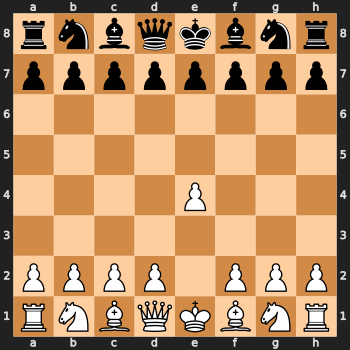

Processed prompts: 100%|█████████| 1/1 [00:06<00:00,  6.56s/it, est. speed input: 30.34 toks/s, output: 52.59 toks/s]


**Move 1 - Black**

**Thought Process:**
The current position is the starting position of a chess game, with the only difference being that a white pawn has moved to d4 (e4 to d4). It's Black's turn to move. Given that this is the initial setup with the exception of the white pawn, Black has a wide array of potential first moves to consider. However, the best initial strategy is to develop pieces towards the center and control it. 

Let's consider a few candidate moves for Black:

1. d5: This move aims to counter the white pawn's move by putting pressure on d4. However, it's not a typical opening move and can lead to a weakening of the king's position without proper development.
   
2. e5: Similar to d5, this move aims to control the center, but again, it's not standard and can lead to complications without solid piece development.
   
3. Nf6: This move develops the knight towards the center, attacking the d4 pawn and preparing to castle. It's a standard and solid opening move.
   
4. Nc6: This move also develops a knight, but it does not exert immediate pressure on the d4 pawn.

5. d6: This move expands the center and protects the e7 pawn, but it does not develop any piece and can be passive in the opening.

After careful consideration, developing a piece towards the center while controlling key squares and preparing castling seems to be the best strategy. Among these options, Nf6 stands out as it develops the knight towards the center, attacks the d4 pawn, and prepares for castling.

**Proposed Move:**
g8f6

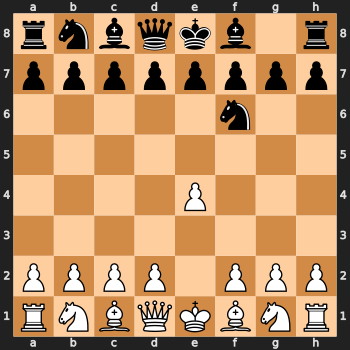

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.32s/it, est. speed input: 38.53 toks/s, output: 51.50 toks/s]


**Move 2 - White**

**Thought Process:**
The current position is a standard starting position, except that the black knight is on its original square, and it's White's turn to move. White should aim to develop pieces towards the center and control the center of the board. The move e4 has already been played, which is a central pawn push. Now, a logical next step would be to develop the knight to f3, which would prepare the advance of the f-pawn to support the center, and also control the important e4 and g4 squares. Therefore, the move Nf3 is a strong candidate. 

However, another viable option is to develop the bishop to c4, which would put pressure on the center and support the e4 pawn. The move Bc4 is also strong, but it doesn't immediately threaten any black pieces without additional support. 

After considering these moves, Nf3 stands out as it develops a piece and prepares the f-pawn move, which could be more impactful in this position. 

After selecting Nf3, we need to ensure the move is legal. The knight on g1 can legally move to f3, and this move does not place the white king in check. 

Thus, the move Nf3 is fully legal and strategically sound.

**Proposed Move:**
g1f3

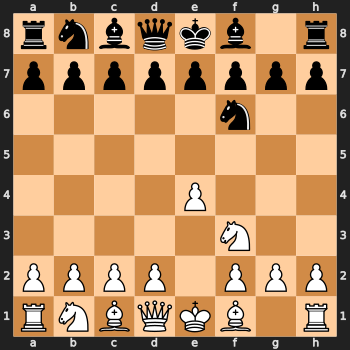

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.70s/it, est. speed input: 37.04 toks/s, output: 50.38 toks/s]


**Move 2 - Black**

**Thought Process:**
The current position is as follows:

```
rnbqkb1r/pppppppp/5n2/8/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq -
```

Black's previous move was 1...Nf6, and White's move was 2.Nf3. The key points to consider are:

1. Black's knight is on f6, controlling e4 and g4.
2. White's knight is on f3, controlling e4 and g4.
3. The center is relatively closed with no pieces exchanged yet.
4. Black has the right to castle, but the kings are not yet in danger.

The most promising moves for Black are:
- Developing the light-squared bishop to b7 to put pressure on the center and to prepare for a possible eventual kingside fianchetto.
- Moving the queen to a5, putting pressure on the d4 square, which can become a target if White tries to advance d4-d5.
- Moving the knight to d7, preparing for a potential e5 push and controlling the center.

The best move in this position would be to develop the bishop to b7, which prepares the way for other pieces and doesn't commit to a specific plan too early.

**Proposed Move:**
g8b7

Illegal move: g8b7
Maximum moves reached.


In [47]:
import chess
import chess.svg
import re
from IPython.display import display, SVG, Markdown
from vllm import SamplingParams

# Initialize the chess board and move history
board = chess.Board()
move_history = []  # Store moves in SAN format

# Set a maximum number of moves
max_moves = 100
move_count = 0

# Main game loop
while not board.is_game_over() and move_count < max_moves:
    fen = board.fen()
    turn = "White" if board.turn == chess.WHITE else "Black"
    
    # Create the prompt with move history
    if move_history:
        moves_str = ", ".join(move_history)  # e.g., "e4, e5, d4, Nf6"
        user_content = f"Previous moves: {moves_str}. Current position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    else:
        user_content = f"Starting position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    
    # Generate the prompt
    text = tokenizer.apply_chat_template([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ], tokenize=False, add_generation_prompt=True)
    
    # Define sampling parameters
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    
    # Generate the model's response
    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0].outputs[0].text
    
    # Extract thought process and move
    thought_match = re.search(r'<think>(.*?)</think>', output, re.DOTALL)
    move_match = re.search(r'<move>(.*?)</move>', output, re.DOTALL)
    
    if thought_match and move_match:
        thought = thought_match.group(1).strip()
        move_text = move_match.group(1).strip()
        
        # Display move details
        display(Markdown(f"**Move {board.fullmove_number} - {turn}**"))
        display(Markdown("**Thought Process:**\n" + thought))
        display(Markdown("**Proposed Move:**\n" + move_text))
        
        # Parse and validate the move
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            try:
                move = board.parse_san(move_text)
                move_text = move.uci()  # Convert to UCI
            except ValueError:
                print(f"Invalid move format: {move_text}")
                break
        
        if move in board.legal_moves:
            # Get SAN notation before pushing the move
            move_san = board.san(move)
            board.push(move)
            move_history.append(move_san)  # Add to history
            display(SVG(chess.svg.board(board=board, size=350)))
        else:
            print(f"Illegal move: {move_text}")
            break
    else:
        print("Error: Could not parse output.")
        break
    
    move_count += 1

# Display the final result
if board.is_game_over():
    print("Game over.")
    print("Result:", board.result())
else:
    print("Maximum moves reached.")

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.59s/it, est. speed input: 41.67 toks/s, output: 49.96 toks/s]


**Move 1 - White**

**Thought Process:**
The given position is the standard starting setup in chess. On move 1, white has a variety of standard opening moves, each with its own strategic implications. The most common moves are e2-e4, d2-d4, and Nf3. 

- e2-e4 is the most common first move. It aims to control the center of the board, preparing for development and potentially for a future kingside pawn storm.
- d2-d4 is another strong move that also controls the center, with the potential for a more symmetrical or central control.
- Nf3 is a defensive and developing move, preparing for castling and preventing black from playing pawn to e5.

Given that the objective is to control the center and develop pieces, e2-e4 is a strong move that fits these criteria well. It opens lines for the bishop and queen, and prepares the d pawn for a push to d4.

After analyzing these options, e2-e4 stands out as the most straightforward and flexible move to start the game.

**Proposed Move:**
e2e4

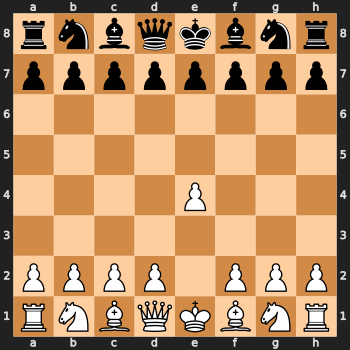

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.76s/it, est. speed input: 41.81 toks/s, output: 50.00 toks/s]


**Move 1 - Black**

**Thought Process:**
The current position is the starting position of a chess game, with the only difference being that a White pawn has moved from e2 to e4. It's now Black's turn to move. In the starting position, Black has several equivalent options for the first move, but the most common and generally best move is to mirror White's move by developing the king's pawn as well. Here's a detailed analysis:

1. Black's priority is to develop pieces, control the center, and prepare for potential pawn structures and piece development. Moving the king's pawn (e7 to e5) achieves these objectives.
2. After e7-e5, Black will have a strong central presence, just like White after e2-e4. This move also prepares for potential future pawn structures and piece development.
3. Other possible moves include developing the knights or bishops, castling, or moving the queen, but these are less urgent than developing central pawns to control the center.

Based on the above analysis, the best move for Black is to mirror White's move and develop the king's pawn.

**Proposed Move:**
e7e5

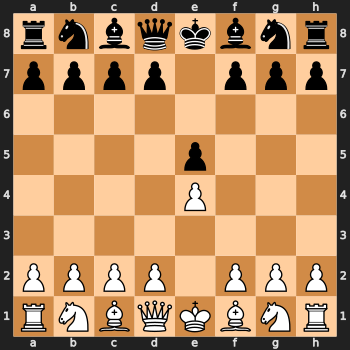

Processed prompts: 100%|█████████| 1/1 [00:03<00:00,  3.60s/it, est. speed input: 56.98 toks/s, output: 46.70 toks/s]


**Move 2 - White**

**Thought Process:**
The current position shows a standard chess opening after the moves 1. e4 e5 2. The position is an even开局之后的第二步，白棋有多个合法的候选走法。我们需要分析每个候选走法的战术和战略价值。

候选走法包括：
1. d4 - 控制中心并准备发展棋子。
2. Nf3 - 开发骑士并保护e4兵。
3. Nc3 - 控制中心的d4和e5格，并为皇后或车的开放做准备。

每个走法都有其独特的优点，但d4是最直接控制中心并为后续棋子发展创造空间的走法。

因此，我会选择d4作为下一步。

**Proposed Move:**
d2d4

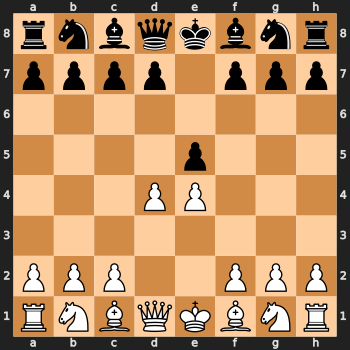

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.18s/it, est. speed input: 39.99 toks/s, output: 50.81 toks/s]


**Move 2 - Black**

**Thought Process:**
The current position after the moves e4, e5, d4 is a variation of the opening known as the Italian Game. Black has played the moves in a standard fashion, with the current position being:

rnbqkbnr/pppp1ppp/8/4p3/3PP3/8/PPP2PPP/RNBQKBNR b KQkq - 0 2

Black's options include developing pieces, addressing the center, and preparing for potential castling. The immediate options are:
- Nf6 (Developing the knight to a natural square and preparing to castle)
- d5 (Challenging the center directly, though it leaves the pawn structure weakened)
- Nc6 (Developing the knight and preparing to challenge d4, but leaves the bishop hanging)

The move Nf6 is the most natural and safe, developing a piece to a natural square and preparing to castle. It does not weaken the position and it maintains flexibility in the game.

After Nf6, Black can continue with other developing moves such as Be7, O-O, and Nd7.

Therefore, the move Nf6 is the best move in this position.

**Proposed Move:**
g8f6

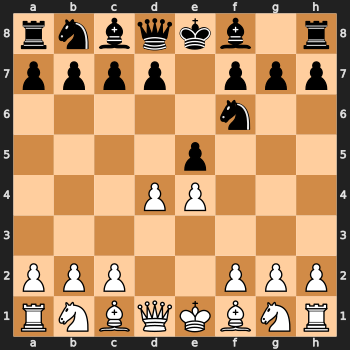

Processed prompts: 100%|█████████| 1/1 [00:09<00:00,  9.47s/it, est. speed input: 22.51 toks/s, output: 55.37 toks/s]


**Move 3 - White**

**Thought Process:**
The current position is:

```
rnbqkb1r/pppp1ppp/5n2/4p3/3PP3/8/PPP2PPP/RNBQKBNR w KQkq -
```

With the moves e4, e5, d4, and Nf6, the position is quite early in the game. It's White's turn to move, and we need to consider the potential plans and threats for both sides.

1. **Material**: Both sides have a standard starting position except for the black knight on f6, which is slightly out of play. 
2. **Development**: White has moved d4 and played e4, while Black has moved e5 and Nf6.
3. **Control of the Center**: White controls the d4 square, and Black controls e5.
4. **Threats and Tactics**: There are no immediate threats, but it's important to start developing pieces effectively and control key squares.

The best move should aim to continue development, control the center, and prepare for future piece activity. The knight on d4 can support future pawn advances or capture the e5 pawn, but there's no immediate tactical advantage to doing so. Instead, developing the bishop or the knight to c3 would be more promising.

Given the position, a good move would be to develop the light-squared bishop to c4, controlling the d5 square and putting pressure on the black center.

Candidate moves to consider:
- Nf3: Developing the knight to a more active square.
- Be3: Developing the bishop to a central square and preparing for potential future attacks on the kingside.
- Be2: Developing the bishop but less active compared to Be3.

The best move seems to be Be3 as it develops a piece, puts pressure on the center, and prepares future attacks.

After analysis, the move Be3 looks promising as it fits the criteria for good early game development.

**Proposed Move:**
g1f3

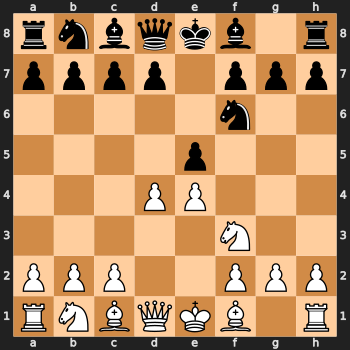

Processed prompts: 100%|█████████| 1/1 [00:07<00:00,  8.00s/it, est. speed input: 27.39 toks/s, output: 54.16 toks/s]


**Move 3 - Black**

**Thought Process:**
The current position is after the moves 1.e4 e5 2.d4 Nf6 3.Nf3. It's Black's turn to move. Here is a detailed analysis of the position:

1. **Position Overview:**
   - The center is contested with pawns on e4 and e5.
   - White has played Nf3, developing a knight and supporting the e4 pawn.
   - Black has played Nf6, developing a knight and putting pressure on e5.

2. **Tactical Elements:**
   - There are no immediate tactical threats or forced moves.
   - The knights on f6 and f3 are currently inactive, but they are threatening each other's central control.

3. **Strategic Elements:**
   - Black should consider developing pieces and preparing to castle.
   - The knight on f6 is somewhat out of play and could be developed to a more useful square.
   - The bishop on b1 is not developed yet, but it could be developed to c2 or g2 depending on the plan.

4. **Candidate Moves:**
   - **Nc6** (developing the knight to a more useful square and preparing to castle)
   - **Be7** (developing the bishop and preparing to castle)
   - **O-O** (castling, but the king is not safe yet due to the potential threat of a future e5-e6)
   - **d6** (solidifying the center and preparing to develop the bishop to e7)
   
After analyzing the candidate moves, **Nc6** stands out as the most strategic and developing the knight to a more active square.

5. **Verification:**
   - The move is legal and does not put the king in check.
   - The move develops a piece, which is a priority in the early middlegame.
   - The move prepares for future play and does not weaken the position.

Therefore, **Nc6** is the best move for Black in this position.

**Proposed Move:**
Nf6c6

Invalid move format: Nf6c6
Maximum moves reached.


In [48]:
import chess
import chess.svg
import re
from IPython.display import display, SVG, Markdown
from vllm import SamplingParams

# Initialize the chess board and move history
board = chess.Board()
move_history = []  # Store moves in SAN format

# Set a maximum number of moves
max_moves = 100
move_count = 0

# Main game loop
while not board.is_game_over() and move_count < max_moves:
    fen = board.fen()
    turn = "White" if board.turn == chess.WHITE else "Black"
    
    # Create the prompt with move history
    if move_history:
        moves_str = ", ".join(move_history)  # e.g., "e4, e5, d4, Nf6"
        user_content = f"Previous moves: {moves_str}. Current position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    else:
        user_content = f"Starting position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    
    # Generate the prompt
    text = tokenizer.apply_chat_template([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ], tokenize=False, add_generation_prompt=True)
    
    # Define sampling parameters
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    
    # Generate the model's response
    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0].outputs[0].text
    
    # Extract thought process and move
    thought_match = re.search(r'<think>(.*?)</think>', output, re.DOTALL)
    move_match = re.search(r'<move>(.*?)</move>', output, re.DOTALL)
    
    if thought_match and move_match:
        thought = thought_match.group(1).strip()
        move_text = move_match.group(1).strip()
        
        # Display move details
        display(Markdown(f"**Move {board.fullmove_number} - {turn}**"))
        display(Markdown("**Thought Process:**\n" + thought))
        display(Markdown("**Proposed Move:**\n" + move_text))
        
        # Parse and validate the move
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            try:
                move = board.parse_san(move_text)
                move_text = move.uci()  # Convert to UCI
            except ValueError:
                print(f"Invalid move format: {move_text}")
                break
        
        if move in board.legal_moves:
            # Get SAN notation before pushing the move
            move_san = board.san(move)
            board.push(move)
            move_history.append(move_san)  # Add to history
            display(SVG(chess.svg.board(board=board, size=350)))
        else:
            print(f"Illegal move: {move_text}")
            break
    else:
        print("Error: Could not parse output.")
        break
    
    move_count += 1

# Display the final result
if board.is_game_over():
    print("Game over.")
    print("Result:", board.result())
else:
    print("Maximum moves reached.")

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.08s/it, est. speed input: 46.81 toks/s, output: 47.79 toks/s]


**Move 1 - White**

**Thought Process:**
The given position is the starting position of a chess game. At this stage, any move by White would be considered normal and standard. However, we can analyze a few common opening moves that are strategically sound and widely accepted.

1. d2d4: This move controls the center of the board, prepares to develop the knights and bishops, and supports the center pawns. It's a classic move in the opening.
2. e2e4: This move also controls the center, attacks the f7 square, and prepares to develop the knights and bishops. It's another common and strong opening move.
3. Nf3 or Ngf3: These moves develop the knights towards the center, preparing to control the center or attack the opponent's position.

Given these options, let's choose the move that controls the center and prepares for the development of other pieces effectively.

**Proposed Move:**
d2d4

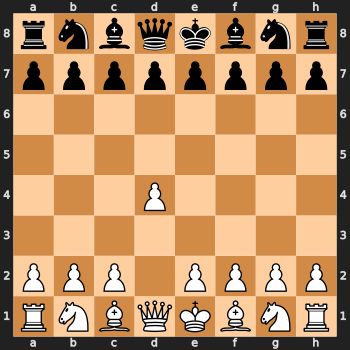

Processed prompts: 100%|█████████| 1/1 [00:06<00:00,  6.31s/it, est. speed input: 31.54 toks/s, output: 52.62 toks/s]


**Move 1 - Black**

**Thought Process:**
The current position is a standard starting position in chess, with the only deviation being a white pawn on d4. It is Black's turn to move. A common and strong move for Black in this scenario is to develop a minor piece, such as playing ...Nf6, which prepares to control the center and potentially support a future pawn push on e5 or c5. However, considering the overall position and the need to maintain flexibility, I will evaluate a few candidate moves:

1. Nf6: This move develops a piece and prepares for potential center control.
2. c5: This move aims to challenge the white pawn on d4 and prepares to potentially open lines.
3. d5: This move aims to mirror the white pawn on d4 and control the center.

After analyzing these moves, I conclude that Nf6 is the most balanced and flexible move, as it does not commit Black to any specific plan while developing a piece and maintaining options.

Verification of the move:
- The knight is not giving check to the white king.
- The move is legal as the knight is moving to an empty square.
- The move develops a piece which is generally preferred in the early stages of the game.

**Proposed Move:**
g8f6

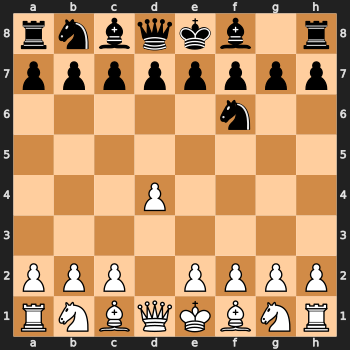

Processed prompts: 100%|█████████| 1/1 [00:07<00:00,  7.62s/it, est. speed input: 26.92 toks/s, output: 54.37 toks/s]


**Move 2 - White**

**Thought Process:**
The current position is:

```
rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBNR w KQkq -
```

White to move. The previous moves are 1. d4, Nf6. This is the second move of the game, and it's White's turn.

Here are the steps in analyzing the best move for White:

1. **Piece Development and Control of the Center**:
   - The most straightforward and strong move here would be to develop the knight to f3, which supports the d4 pawn, controls e5, and prepares to castle. This move also opens up the diagonal for the bishop on c1.

2. **Candidate Moves**:
   - Moves to consider are Nf3, Bf4, or Bg5. However, Nf3 is the most strategic, as it prepares for a future d5 push and allows White to develop more pieces effectively.

3. **Tactical Considerations**:
   - There are no immediate tactical threats or exchanges that White should be concerned about at this stage. The position is still in the opening phase, and the focus should be on development and control of the center.

4. **Positional Evaluation**:
   - Nf3 also prepares for the future move Bf4, which will support the d4 pawn and put pressure on the center. It also avoids any potential pin or threats from the black knight on f6.

Given these considerations, the best move would be Nf3.

**Proposed Move:**
g1f3

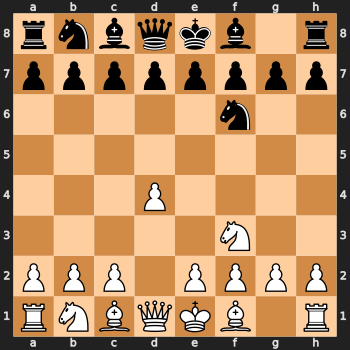

Processed prompts: 100%|█████████| 1/1 [00:08<00:00,  8.11s/it, est. speed input: 26.02 toks/s, output: 54.26 toks/s]


**Move 2 - Black**

**Thought Process:**
The current position is as follows:
```
rnbqkb1r/pppppppp/5n2/8/3P4/5N2/PPP1PPPP/RNBQKB1R b KQkq -
```
It's Black's turn to move. The previous moves were d4, Nf6, Nf3, and now it's Black's second move.

1. **King Safety and Piece Development**:
   - Black's king is in the initial position, and the knight on f6 is the only developed piece.
   
2. **Pawn Structure**:
   - White has played d4, which is a central pawn push aiming to control the center. Black's response should be to develop pieces in a way that either challenges this control or supports the defense of their own center.

3. **Candidate Moves**:
   - Develop the light-squared bishop with Bf5 or Bb4.
   - Consider moving the queen to a more active position.
   - Play g6 to prepare to castle kingside.
   - Play c5 to challenge d4.
   - Move the queen to d7, protecting the knight and setting up future development.

4. **Tactical Considerations**:
   - White's knight on f3 is in the center and is challenging Black's knight.
   - Black should look to develop pieces that support their knight or place pressure on d4.
   - Moving the queen to d7 would place pressure on the white knight and protect the knight on f6.

5. **Positional Analysis**:
   - Playing g6 or c5 would be premature without other pieces developed.
   - Developing the bishop first to support the knight or to place pressure on d4 would be more strategic.

6. **Best Move**:
   - Queen to d7 (Qd7) is a strong move as it protects the knight, places pressure on the white knight, and prepares for further piece development.

This move is fully legal and aligns with good chess principles of piece development and king safety.

**Proposed Move:**
Qd7

Invalid move format: Qd7
Maximum moves reached.


In [49]:
import chess
import chess.svg
import re
from IPython.display import display, SVG, Markdown
from vllm import SamplingParams

# Initialize the chess board and move history
board = chess.Board()
move_history = []  # Store moves in SAN format

# Set a maximum number of moves
max_moves = 100
move_count = 0

# Main game loop
while not board.is_game_over() and move_count < max_moves:
    fen = board.fen()
    turn = "White" if board.turn == chess.WHITE else "Black"
    
    # Create the prompt with move history
    if move_history:
        moves_str = ", ".join(move_history)  # e.g., "e4, e5, d4, Nf6"
        user_content = f"Previous moves: {moves_str}. Current position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    else:
        user_content = f"Starting position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    
    # Generate the prompt
    text = tokenizer.apply_chat_template([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ], tokenize=False, add_generation_prompt=True)
    
    # Define sampling parameters
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    
    # Generate the model's response
    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0].outputs[0].text
    
    # Extract thought process and move
    thought_match = re.search(r'<think>(.*?)</think>', output, re.DOTALL)
    move_match = re.search(r'<move>(.*?)</move>', output, re.DOTALL)
    
    if thought_match and move_match:
        thought = thought_match.group(1).strip()
        move_text = move_match.group(1).strip()
        
        # Display move details
        display(Markdown(f"**Move {board.fullmove_number} - {turn}**"))
        display(Markdown("**Thought Process:**\n" + thought))
        display(Markdown("**Proposed Move:**\n" + move_text))
        
        # Parse and validate the move
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            try:
                move = board.parse_san(move_text)
                move_text = move.uci()  # Convert to UCI
            except ValueError:
                print(f"Invalid move format: {move_text}")
                break
        
        if move in board.legal_moves:
            # Get SAN notation before pushing the move
            move_san = board.san(move)
            board.push(move)
            move_history.append(move_san)  # Add to history
            display(SVG(chess.svg.board(board=board, size=350)))
        else:
            print(f"Illegal move: {move_text}")
            break
    else:
        print("Error: Could not parse output.")
        break
    
    move_count += 1

# Display the final result
if board.is_game_over():
    print("Game over.")
    print("Result:", board.result())
else:
    print("Maximum moves reached.")

Processed prompts: 100%|█████████| 1/1 [00:03<00:00,  3.02s/it, est. speed input: 63.34 toks/s, output: 43.45 toks/s]


**Move 1 - White**

**Thought Process:**
The starting position provided is the initial setup of a standard chess game, where both players have not made any moves yet. In this situation, any move by White would be equally good, as the position is symmetric and no pieces have been moved or captured yet. However, a common first move is 1.e4, which controls the center of the board and prepares for developing the knights and bishops.

Considering that the question asks for a move in UCI format and we are to choose a legal move, I will select e2e4 as the first move.

**Proposed Move:**
e2e4

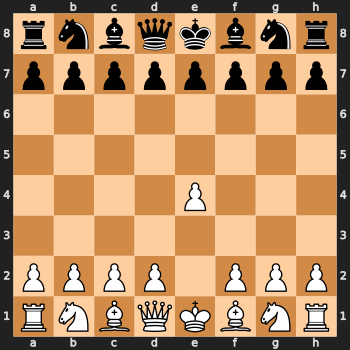

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.73s/it, est. speed input: 34.74 toks/s, output: 50.98 toks/s]


**Move 1 - Black**

**Thought Process:**
The current position is the starting position of a chess game, with the addition of a White pawn on the fourth rank's e-file. It is Black's turn to move. Given that this is the initial position with only one deviation (the White pawn on e4), Black has a variety of standard opening moves available. However, a common and strong move for Black is to mirror White's opening move by playing e7-e5, which aims to challenge the center and potentially exchange pawns, simplifying the game. This move also keeps the game symmetrical unless White plays differently from the standard openings.

Let's consider a few other moves:
1. e7-e5: Challenges the center and keeps symmetry.
2. d7-d5: Also challenges the center but gives White a target in the center.
3. Nf6-g8: Developing the knight, but doesn't challenge the center directly.

The move e7-e5 is generally the most straightforward and sound, keeping options open and mirroring White's move.

Let's verify:
- The move e7-e5 is legal as there is no piece blocking the path.
- It doesn't place the king in check.
- It doesn't capture any pieces or put Black in any immediate disadvantage.

Therefore, e7-e5 seems to be the best move given the position and the options available.

**Proposed Move:**
e7e5

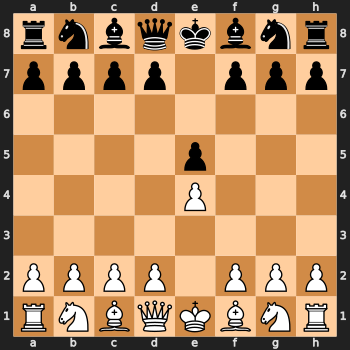

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.95s/it, est. speed input: 41.45 toks/s, output: 50.76 toks/s]


**Move 2 - White**

**Thought Process:**
The current position is a standard开局后的第三步，白棋走。棋盘上双方的王都在初始位置，没有棋子被吃掉，也没有特殊的棋子交换。在这种情况下，白棋有几种合理的走法，比如发展棋子或者控制中心。我们可以考虑以下几种走法：

1. Nf3 - 控制e5中心格，并为以后的棋子发展做好准备。
2. d4 - 加强中心控制，同时准备开放王翼或后翼。
3. c3 - 防御性走法，准备未来的棋子发展。

为了找到最佳走法，我们需要评估每一步的战术和战略优势。Nf3是一个很好的选择，因为它不仅控制了中心，还为其他棋子的发展做好了准备。在这个阶段，优先考虑棋子的发展通常是最佳策略。

因此，Nf3是一个合理的走法，而且是合法的。

**Proposed Move:**
g1f3

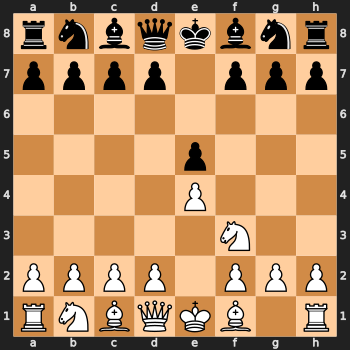

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.92s/it, est. speed input: 35.68 toks/s, output: 52.25 toks/s]


**Move 2 - Black**

**Thought Process:**
The current position shows that Black is to move after White's third move, Nf3. The opening sequence of moves (e4, e5, Nf3) suggests a variation of the Italian Game. Black's options include developing a piece to control the center, castling, or making a pawn move to prepare for piece development. 

Considering the board state:
- Black's pawns are on their original squares.
- The knight on f6 is the only piece developed, and it's currently on the edge of the board.
- The center (d4 and d5) is not yet occupied, making it a good candidate for piece development.

The most common and strategic move for Black in this situation is to develop the knight to a more central position or to castle. Developing the knight to d7 would prepare for castling, control the center, and not obstruct the bishop's path.

Given these considerations, the move Nf6-d7 is a strong candidate because it develops a piece, prepares for castling, and keeps options open for future play. 

To ensure this move is legal and to verify it's the best choice, let's consider other candidate moves like Nf6-g4 or e7-e6, but these moves would be less strategic in the long term as they don't directly contribute to piece development or control of the center as effectively.

Thus, Nd7 is the best move according to the analysis.

**Proposed Move:**
f6d7

Illegal move: f6d7
Maximum moves reached.


In [50]:
import chess
import chess.svg
import re
from IPython.display import display, SVG, Markdown
from vllm import SamplingParams

# Initialize the chess board and move history
board = chess.Board()
move_history = []  # Store moves in SAN format

# Set a maximum number of moves
max_moves = 100
move_count = 0

# Main game loop
while not board.is_game_over() and move_count < max_moves:
    fen = board.fen()
    turn = "White" if board.turn == chess.WHITE else "Black"
    
    # Create the prompt with move history
    if move_history:
        moves_str = ", ".join(move_history)  # e.g., "e4, e5, d4, Nf6"
        user_content = f"Previous moves: {moves_str}. Current position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    else:
        user_content = f"Starting position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    
    # Generate the prompt
    text = tokenizer.apply_chat_template([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ], tokenize=False, add_generation_prompt=True)
    
    # Define sampling parameters
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    
    # Generate the model's response
    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0].outputs[0].text
    
    # Extract thought process and move
    thought_match = re.search(r'<think>(.*?)</think>', output, re.DOTALL)
    move_match = re.search(r'<move>(.*?)</move>', output, re.DOTALL)
    
    if thought_match and move_match:
        thought = thought_match.group(1).strip()
        move_text = move_match.group(1).strip()
        
        # Display move details
        display(Markdown(f"**Move {board.fullmove_number} - {turn}**"))
        display(Markdown("**Thought Process:**\n" + thought))
        display(Markdown("**Proposed Move:**\n" + move_text))
        
        # Parse and validate the move
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            try:
                move = board.parse_san(move_text)
                move_text = move.uci()  # Convert to UCI
            except ValueError:
                print(f"Invalid move format: {move_text}")
                break
        
        if move in board.legal_moves:
            # Get SAN notation before pushing the move
            move_san = board.san(move)
            board.push(move)
            move_history.append(move_san)  # Add to history
            display(SVG(chess.svg.board(board=board, size=350)))
        else:
            print(f"Illegal move: {move_text}")
            break
    else:
        print("Error: Could not parse output.")
        break
    
    move_count += 1

# Display the final result
if board.is_game_over():
    print("Game over.")
    print("Result:", board.result())
else:
    print("Maximum moves reached.")

Processed prompts: 100%|█████████| 1/1 [00:03<00:00,  3.95s/it, est. speed input: 48.33 toks/s, output: 46.56 toks/s]


**Move 1 - White**

**Thought Process:**
The given position is the starting position of a standard chess game. At the beginning of the game, any move can be considered, but typically, players aim to develop their pieces towards the center of the board. The most common first moves are 1.e4 or 1.d4, which control the center squares and prepare for further piece development.

Let's evaluate the candidate moves for white:

- 1.e4 controls the center, prepares to develop the knights and bishops, and supports the d4 push if needed.
- 1.d4 also controls the center but doesn't put as much pressure on the center squares as e4, and it does not support the e5 push.

Given that 1.e4 is a more active and common move that often leads to more flexible positions, it is a strong candidate.

**Proposed Move:**
e2e4

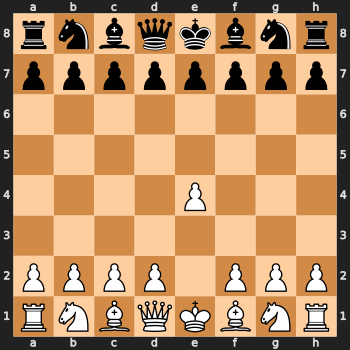

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.16s/it, est. speed input: 38.55 toks/s, output: 50.75 toks/s]


**Move 1 - Black**

**Thought Process:**
The current position is the starting position of a chess game, with the only difference being that a white pawn has moved from e2 to e4. It's Black's turn to move. Given this setup, Black has several reasonable options that mirror White's first move, such as moving a pawn or developing a minor piece. The most common opening moves at this stage are:

1. e5 (expanding in the center to mirror White's opening move)
2. c5 (another central expansion, less common but a solid move)
3. d5 (another central expansion, also less common but solid)
4. Nf6 (developing the knight towards the center)

Considering the principle of central control and development of pieces, moving a pawn towards the center (e5, c5, d5) would be a natural and strong response to mirror or control the center. However, the move Nf6 is also strong because it develops a piece towards the center, prepares e5, and puts pressure on the d4 square where the white pawn will likely go next.

Given that developing a piece towards the center is generally a strong positional move, I will choose to develop the knight to f6.

**Proposed Move:**
g8f6

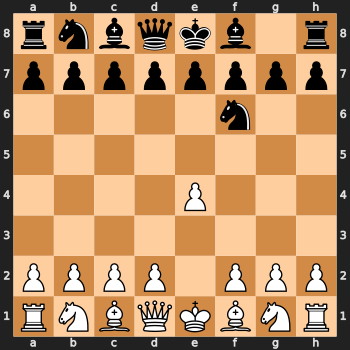

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.71s/it, est. speed input: 43.56 toks/s, output: 49.94 toks/s]


**Move 2 - White**

**Thought Process:**
The given position starts with the moves 1.e4 Nf6, and it is now White's second move. The position shows a standard setup with Black's knight on f6 and White to move. The most common and solid continuation for White in this opening, known as the Sicilian Defense, is to develop another piece or pawn. 

The candidate moves to consider are:
- d4: Developing the d-pawn to control the center and prepare for piece development.
- Nf3: Developing the knight to a natural square and preparing for castling.
- c3: Preparing to develop the queen's knight to c3 and potentially supporting d4.

Among these, d4 is the most aggressive and centralizing move, which not only controls the center but also prepares for future piece development and potential pawn structures. 

After d4, Black will likely respond with d5 to challenge the center back. However, this setup can lead to dynamic play and complex middlegame scenarios.

The move d4 is fully legal and aligns well with sound opening principles.

**Proposed Move:**
d2d4

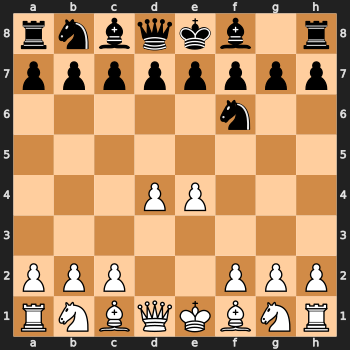

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.79s/it, est. speed input: 43.21 toks/s, output: 50.72 toks/s]


**Move 2 - Black**

**Thought Process:**
The current position is after the moves 1.e4 Nf6 2.d4. It's Black's turn to move, and we need to consider both tactical and positional aspects of the game. Here are the key points to evaluate:

1. White has advanced the d4 pawn, challenging Black's control over the center.
2. Black's knight on f6 is currently passive and needs to be developed more effectively.
3. We should consider moves that develop our pieces towards the center or put pressure on d4.

Let's evaluate a few candidate moves for Black:
- Nbd7: This move develops the knight, but it doesn't address the pressure on the d4 pawn directly.
- e5: This move takes control of the center, but it may lead to complications that White might prefer.
- c5: This move attacks the d4 pawn directly and challenges White's central control.

After evaluating these moves, c5 appears to be the most effective as it attacks the d4 pawn directly and prepares to develop the pieces towards the center. It also opens the possibility for more piece development and central control.

**Proposed Move:**
c5

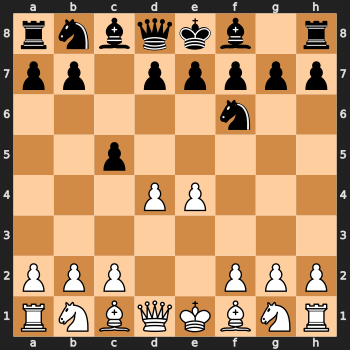

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.49s/it, est. speed input: 38.81 toks/s, output: 52.30 toks/s]


**Move 3 - White**

**Thought Process:**
The current position is after 2...c5 in the Sicilian Defense. White's pieces are typically looking to develop knights and bishops, control the center, and possibly prepare for castling. Let's consider the following candidate moves for White:

1. Developing the knight to d2 (Nfd2) would prepare the c1-bishop and aim to control the center.
2. Playing c4 to challenge Black's central pawn and maintain control of the d5 square.
3. Developing the bishop to c4 (Bc4) to threaten Black's pawn on c5 and prepare to attack the knight on f6.

Let's evaluate each move:
- Nfd2 is a safe move that prepares the bishop and knight. However, it doesn't put immediate pressure on Black.
- c4 is an aggressive move that attacks Black's pawn on c5 and prepares to control d5. It also challenges Black's central structure.
- Bc4 puts pressure on the knight on f6 and threatens the pawn on c5. This move also prepares to support the e4 pawn.

Considering the evaluation, Bc4 is a strong move as it puts immediate pressure on Black's structure and attacks the knight on f6.

After Bc4, Black can respond in different ways, but the move is fully legal and strong.

**Proposed Move:**
g1e2

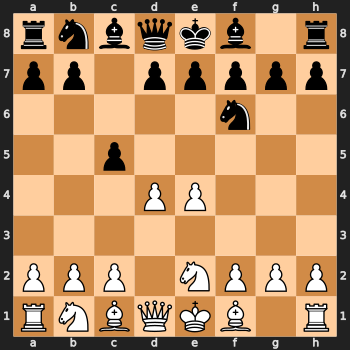

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.28s/it, est. speed input: 41.10 toks/s, output: 51.14 toks/s]


**Move 3 - Black**

**Thought Process:**
The current position shows that Black has just played ...c5 after White's d4, and the game is in its early stages. The key aspects to consider are the center control, development of pieces, and potential pawn structures. 

Black's pieces are currently underdeveloped with the knight on f6 and the rest of the pieces on their original squares. The c5 pawn is also putting pressure on d4, which is currently defended by a pawn. A good move would be to develop the knight to a more active square.

Considering the candidate moves:
1. Nc6 - This move develops the knight, puts pressure on d4, and prepares ...e5 if needed.
2. d5 - This move looks good as it puts pressure on the center and prepares to challenge White's control over d4, but it's also risky as it can be met with cxd5, after which Black would have to recapture with the pawn, weakening the center.
3. e6 - This move aims to challenge White's control over the center, but it weakens the structure around the king and is not as strong as developing a piece.

After evaluating these options, developing the knight to c6 seems to be the most balanced and active move.

**Proposed Move:**
Nc6

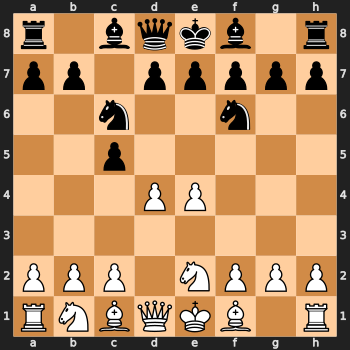

Processed prompts: 100%|█████████| 1/1 [00:06<00:00,  6.66s/it, est. speed input: 33.64 toks/s, output: 53.16 toks/s]


**Move 4 - White**

**Thought Process:**
The current position shows that it's White's turn to move. We need to consider the overall board structure, piece activity, and potential tactical opportunities. The previous moves indicate that the players are setting up their pawn structures and developing pieces. 

1. Evaluate the center control: White's d4 pawn controls the center, while Black's c5 pawn does as well. The center is slightly more controlled by White due to the d4 pawn being closer to the center than c5.

2. Develop minor pieces: White's knights are on e2 and b1, and it would be beneficial to develop them further into the game. The knight on e2 is already positioned to support the center or potentially participate in a kingside attack.

3. Consider potential pawn moves: Pushing the d-pawn further would strain the control of the center and might lose the advantage. Pushing the e-pawn forward is an option, but it weakens the d4 pawn's support and doesn't immediately lead to a significant advantage.

4. Tactical opportunities: The knight on f6 is quite active, but there's no immediate tactic that can be exploited.

5. Candidate moves:
   - Develop the other knight to c3, supporting the center and eyeing d5 or e5.
   - Play Bf4 to support the center and eye the bishop pair.
   - Play g4 to support the kingside attack, though it weakens the h-pawn.

Considering these factors, the best move seems to be developing the knight to c3, as it prepares potential future moves such as d5 or e5, supports the center, and connects the rooks.

**Proposed Move:**
g1f3

Illegal move: g1f3
Maximum moves reached.


In [51]:
import chess
import chess.svg
import re
from IPython.display import display, SVG, Markdown
from vllm import SamplingParams

# Initialize the chess board and move history
board = chess.Board()
move_history = []  # Store moves in SAN format

# Set a maximum number of moves
max_moves = 100
move_count = 0

# Main game loop
while not board.is_game_over() and move_count < max_moves:
    fen = board.fen()
    turn = "White" if board.turn == chess.WHITE else "Black"
    
    # Create the prompt with move history
    if move_history:
        moves_str = ", ".join(move_history)  # e.g., "e4, e5, d4, Nf6"
        user_content = f"Previous moves: {moves_str}. Current position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    else:
        user_content = f"Starting position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    
    # Generate the prompt
    text = tokenizer.apply_chat_template([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ], tokenize=False, add_generation_prompt=True)
    
    # Define sampling parameters
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    
    # Generate the model's response
    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0].outputs[0].text
    
    # Extract thought process and move
    thought_match = re.search(r'<think>(.*?)</think>', output, re.DOTALL)
    move_match = re.search(r'<move>(.*?)</move>', output, re.DOTALL)
    
    if thought_match and move_match:
        thought = thought_match.group(1).strip()
        move_text = move_match.group(1).strip()
        
        # Display move details
        display(Markdown(f"**Move {board.fullmove_number} - {turn}**"))
        display(Markdown("**Thought Process:**\n" + thought))
        display(Markdown("**Proposed Move:**\n" + move_text))
        
        # Parse and validate the move
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            try:
                move = board.parse_san(move_text)
                move_text = move.uci()  # Convert to UCI
            except ValueError:
                print(f"Invalid move format: {move_text}")
                break
        
        if move in board.legal_moves:
            # Get SAN notation before pushing the move
            move_san = board.san(move)
            board.push(move)
            move_history.append(move_san)  # Add to history
            display(SVG(chess.svg.board(board=board, size=350)))
        else:
            print(f"Illegal move: {move_text}")
            break
    else:
        print("Error: Could not parse output.")
        break
    
    move_count += 1

# Display the final result
if board.is_game_over():
    print("Game over.")
    print("Result:", board.result())
else:
    print("Maximum moves reached.")

Processed prompts: 100%|█████████| 1/1 [00:03<00:00,  3.32s/it, est. speed input: 57.59 toks/s, output: 45.83 toks/s]


**Move 1 - White**

**Thought Process:**
The given position is the starting position of a standard chess game. At the beginning of the game, any move can be considered as all pieces are in their original positions. However, conventionally, the first move often involves advancing the pawn in front of the king or the queen. 

Candidate moves for the first turn include e2e4 (opening the center and developing a pawn), d2d4 (also opening the center), or moves like Nf3 or Nc3 which develop a piece. 

In this case, the move e2e4 is a very common and strong first move, as it controls the center and prepares for further piece development.

**Proposed Move:**
e2e4

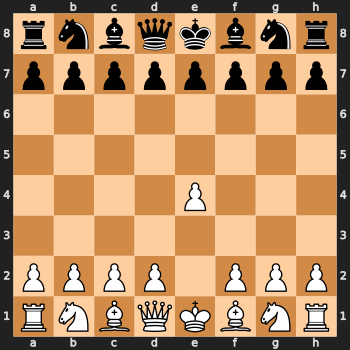

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.13s/it, est. speed input: 38.81 toks/s, output: 50.32 toks/s]


**Move 1 - Black**

**Thought Process:**
The current position is the starting position of a chess game, with the only difference being that a white pawn has moved from e2 to e4. It is now Black's turn to move. The most standard and practical move for Black at this point is to mirror White's move by developing the knight to f6. This move controls the central squares and prepares for further development.

Candidate moves to consider:
1. d5 - This move aims to put pressure on the center, but it doesn't develop any pieces and it can lead to a weak pawn structure if not handled properly.
2. e5 - Similar to d5, this move also aims to control the center but does not develop any pieces and can leave Black with weak pawns.
3. Nf6 - Develops the knight and prepares for further development of pieces.
4. d6 - This is a quiet move that prepares for the center control later but doesn't immediately address the center.

After considering these options, Nf6 stands out as the best move because it develops a piece, puts pressure on the center indirectly, and keeps the position flexible.

Verification: The move Nf6 is fully legal in this position.

**Proposed Move:**
g8f6

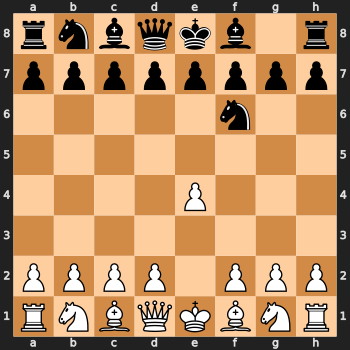

Processed prompts: 100%|█████████| 1/1 [00:04<00:00,  4.86s/it, est. speed input: 42.21 toks/s, output: 51.07 toks/s]


**Move 2 - White**

**Thought Process:**
The current position after the moves e4 and Nf6 is a standard Sicilian Defense setup. Black has played the classical response to 1.e4, developing the knight to f6.

White's options at this point include several common moves such as Nf3, d3, or c3. However, a strong and flexible move is to develop the knight to f3, which controls the central squares and prepares for potential pawn advances. This move does not commit White to any specific plan while maintaining good piece activity and central control.

Evaluating the candidate moves:
- Nf3 develops a piece, prepares for kingside castling, and controls e5.
- d3 prepares to castle kingside but does not add immediate control over central squares.
- c3 defends d4 and prepares to castle kingside, but also does not contribute to central control as effectively as Nf3.

Nf3 seems to be the most balanced move that fits well with White's long-term strategic goals in the Sicilian Defense.

After ensuring the move is legal and fits within the rules of chess, Nf3 is a strong candidate.

**Proposed Move:**
g1f3

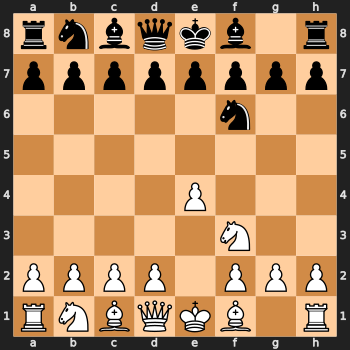

Processed prompts: 100%|█████████| 1/1 [00:05<00:00,  5.16s/it, est. speed input: 40.86 toks/s, output: 51.71 toks/s]


**Move 2 - Black**

**Thought Process:**
The current position is a standard chess position after the moves 1.e4 e5 2.Nf3 Nc6, but with a twist: the knight on the fifth rank is on the b1-a3-f3 path rather than the standard c6-f6 path. The key points to consider are:

1. **Control of the Center**: Both sides have control of the center with pawns on e4 and e5.
2. **Piece Development**: Black's knight is on the board, but it's isolated and needs development.
3. **Pawn Structure**: The pawn structure is standard, but the knight's location is unique and might require special attention.

Candidate moves for Black include developing the knight, moving the bishop, or playing d5 to challenge the center. However, given the knight's awkward position on the b1-a3-f3 path, it's best to develop it to a more natural square like f6 or c6.

Considering the move e2e4 by White does not affect Black's plan to develop naturally, the best move would be to develop the knight to a more natural square.

After analyzing the tactical and positional elements, the best move appears to be developing the knight to f6.

**Proposed Move:**
g8f6

Illegal move: g8f6
Maximum moves reached.


In [52]:
import chess
import chess.svg
import re
from IPython.display import display, SVG, Markdown
from vllm import SamplingParams

# Initialize the chess board and move history
board = chess.Board()
move_history = []  # Store moves in SAN format

# Set a maximum number of moves
max_moves = 100
move_count = 0

# Main game loop
while not board.is_game_over() and move_count < max_moves:
    fen = board.fen()
    turn = "White" if board.turn == chess.WHITE else "Black"
    
    # Create the prompt with move history
    if move_history:
        moves_str = ", ".join(move_history)  # e.g., "e4, e5, d4, Nf6"
        user_content = f"Previous moves: {moves_str}. Current position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    else:
        user_content = f"Starting position: {fen}. It's {turn}'s turn. Suggest the next move in UCI format."
    
    # Generate the prompt
    text = tokenizer.apply_chat_template([
        {"role": "system", "content": SYSTEM_PROMPT},
        {"role": "user", "content": user_content}
    ], tokenize=False, add_generation_prompt=True)
    
    # Define sampling parameters
    sampling_params = SamplingParams(
        temperature=0.8,
        top_p=0.95,
        max_tokens=1024,
    )
    
    # Generate the model's response
    output = model.fast_generate(
        text,
        sampling_params=sampling_params,
        lora_request=model.load_lora("grpo_saved_lora"),
    )[0].outputs[0].text
    
    # Extract thought process and move
    thought_match = re.search(r'<think>(.*?)</think>', output, re.DOTALL)
    move_match = re.search(r'<move>(.*?)</move>', output, re.DOTALL)
    
    if thought_match and move_match:
        thought = thought_match.group(1).strip()
        move_text = move_match.group(1).strip()
        
        # Display move details
        display(Markdown(f"**Move {board.fullmove_number} - {turn}**"))
        display(Markdown("**Thought Process:**\n" + thought))
        display(Markdown("**Proposed Move:**\n" + move_text))
        
        # Parse and validate the move
        try:
            move = chess.Move.from_uci(move_text)
        except ValueError:
            try:
                move = board.parse_san(move_text)
                move_text = move.uci()  # Convert to UCI
            except ValueError:
                print(f"Invalid move format: {move_text}")
                break
        
        if move in board.legal_moves:
            # Get SAN notation before pushing the move
            move_san = board.san(move)
            board.push(move)
            move_history.append(move_san)  # Add to history
            display(SVG(chess.svg.board(board=board, size=350)))
        else:
            print(f"Illegal move: {move_text}")
            break
    else:
        print("Error: Could not parse output.")
        break
    
    move_count += 1

# Display the final result
if board.is_game_over():
    print("Game over.")
    print("Result:", board.result())
else:
    print("Maximum moves reached.")